In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import segyio # não sendo usada
import scipy.signal
import scipy.interpolate
import pylops
import seaborn as sns
import scipy.linalg
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [3]:
# Function that stores the slicing

def slicing(data, index, axis):
    if axis == 'x':
        return data[index, :, :]
    elif axis == 'y':
        return data[:, index, :]
    elif axis == 'z':
        return data[:, :, index]
    else:
        print("Axis must be 0, 1 or 2")
        return None

In [4]:
# The data below is on the usb stick
data_amp = np.load("F:\\Universidade\\IC\\Amplitude\\model0.npy")
data_faults = np.load("F:\\Universidade\\IC\\Faults\\model0.npy")
data_imp = np.load("F:\\Universidade\\IC\\Impedance\\model0.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_faults)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)
 data shape (256, 256, 256)


In [5]:
np.shape(data_imp[:,:,1])

(256, 256)

Gerando a wavelet de Ricker

In [7]:
def ricker(f, length=0.128, dt=0.001):
    t = np.arange(-length/2, (length-dt)/2, dt)
    wlet = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    
    return t, wlet

twlet, wlet = ricker(f=30, length=0.256, dt=0.004)          # wavelet

In [36]:
# Wavelet operator
nz, nx, ny = data_amp.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(wlet/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)


In [66]:
# Get the size along the z-axis
z_size = data_amp.shape[2]

# Initialize an empty array to store the results
m_inv_tbt_all = np.empty_like(data_amp)

# Loop over each slice along the z-axis
for z in range(z_size):
    m_inv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
        Op=PPop, # operador de modelagem direta (G)
        y = data_amp[:, :, z].ravel() / 30000, # dado observado.
        Regs=[],
        epsI=5e-1,
        x0 = data_imp[:, :, z].ravel(), # modelo inicial
        engine='scipy',
        **dict(maxiter=1000)
    )
    # Reshape the result back to the original shape and store it
    m_inv_tbt_all[:, :, z] = m_inv_tbt.reshape(data_amp.shape[0], data_amp.shape[1])

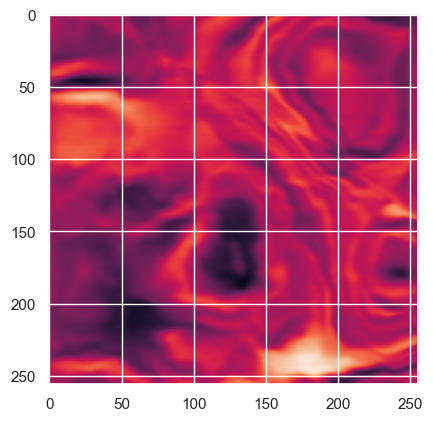

In [68]:

plt.imshow(data_amp[:,:,200])

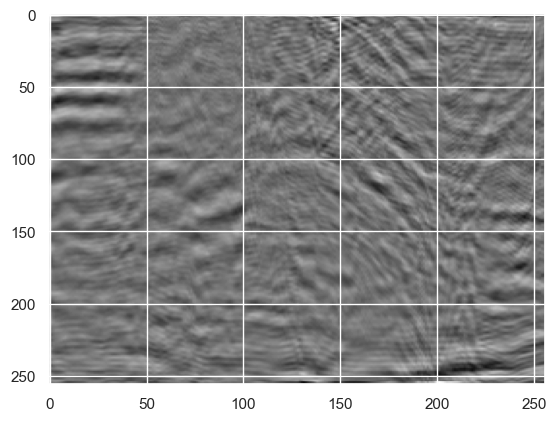

In [53]:
plt.imshow(m_inv_tbt_all[:,:,200], aspect='auto', cmap='gray_r')

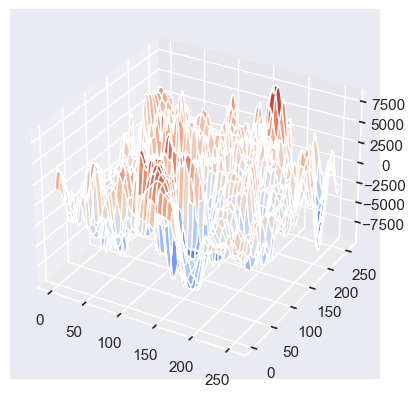

In [82]:
# Get the dimensions of the data
x_dim, y_dim, z_dim = data_amp.shape

# Create x, y, and z coordinate arrays
x, y, z = np.meshgrid(np.arange(x_dim), np.arange(y_dim), np.arange(z_dim), indexing='ij')

fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.plot_surface(x[:,:,128], y[:,:,128], data_amp[:,:,128], cmap='coolwarm')